In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn import metrics
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
%matplotlib inline

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [4]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    preprocess_features = selected_features.copy()
    preprocess_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
    return  preprocess_features

In [5]:
def preprocess_targets(california_housing_dataframe):
    selected_targets = pd.DataFrame()
    selected_targets = (california_housing_dataframe[
        ["median_house_value"]] / 1000)
    return  selected_targets
    

In [6]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets =  preprocess_targets(california_housing_dataframe.head(12000))

In [7]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [8]:
def construct_feature_columns (input_features):
    return set([tf.feature_column.numeric_column(my_features) for my_features in input_features])

In [9]:
def my_input_fn (feature,target,batch_size=1 ,shuffle=True, num_epochs=None):
    feature = {key:np.array(value) for key,value in dict(feature).items()}
    ds = Dataset.from_tensor_slices((feature,target))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds.shuffle(10000)
    feature,label = ds.make_one_shot_iterator().get_next()
    return feature,label

In [10]:
def train_model(learning_rate,steps,batch_size,
    training_examples,training_targets,validation_examples,validation_targets):
    my_optimzer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimzer = tf.contrib.estimator.clip_gradients_by_norm(my_optimzer,5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples),
                                                    optimizer=my_optimzer)
    period = 10
    steps_per_period = steps / period
    training_rmse = []
    validation_rmse = []
    train_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"],batch_size= batch_size)
    training_predict_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"],
                                                batch_size= batch_size,num_epochs=1,shuffle=False)
    validation_predict_fn = lambda: my_input_fn(validation_examples,validation_targets["median_house_value"],
                                                batch_size= batch_size,num_epochs=1,shuffle=False)
    for period in range(0,period):
        linear_regressor.train(input_fn=train_input_fn,steps=steps_per_period)
        training_predictions = linear_regressor.predict(input_fn = training_predict_fn)
        training_predictions = np.array([ item["predictions"][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn = validation_predict_fn)
        validation_predictions = np.array([ item["predictions"][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,validation_targets))
        
        print(training_root_mean_squared_error)
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("finished")
    plt.xlabel="periods"
    plt.ylabel="RMSE"
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse,label="training")
    plt.plot(validation_rmse,label="validation")
    plt.legend()
    plt.show()
    

213.48783381741674
237.13493270911164
231.6066213542442
223.35021881746331
209.3735589585987
205.34111315763124
191.781478832779
191.03707033892826
156.21835092839004
148.11170924793805
finished


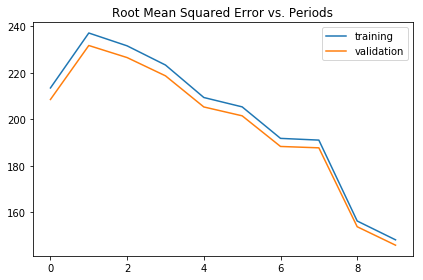

In [11]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

114.52764537044652
110.3487045695451
107.14775955830177
104.2728152160866
100.56268206417664
96.08887404015854
94.12855684694448
92.52742698940806
91.17610085588636
90.02533880154414
finished


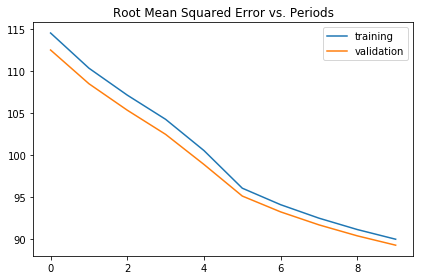

In [14]:
minimal_features = [
  "median_income",
  "latitude",
]
minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.1,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)